In [279]:
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np
import pickle
import pandas as pd
import os
import math
import seaborn as sns
from sklearn.preprocessing import StandardScaler, QuantileTransformer
import sdv

colors = ['#9932CCAF', '#98F5FFAF', '#FFD39BAF', '#8B2323AF', '#FF4040AF', '#0000FFAF', '#E3CF57AF', '#00FFFFAF', '#FF1493AF', '#228B22AF', '#7FFF00AF', '#8B0A50AF', '#5D478BAF']

<h2>Подготовка данных </h2>

<h3>Загрузка данных</h3>

In [280]:
# Данные можно скачать по ссылке: https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset
file_path1 = "heartfinal.csv"
data = pd.read_csv(file_path1, parse_dates=True)
data = data.drop(columns=['index'])

In [281]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,74,1,1,133,190,0,1,122,0,0.798688,0,2,1,0
1,70,1,0,128,153,1,0,136,1,0.302304,0,0,1,0
2,74,0,0,145,193,1,1,143,0,0.876646,0,2,1,0
3,74,0,1,124,165,0,1,131,1,1.615372,0,1,2,0
4,71,1,0,123,179,1,1,142,1,2.599606,0,0,1,0


In [282]:
names = list(data.columns)
names

['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal',
 'target']

<h4> Наличие пропусков и общая статистика

In [283]:
data_without_miss = data.dropna()

print(" len data: {}".format(len(data)))
print(" len data_without_miss: {}".format(len(data_without_miss)))

 len data: 752
 len data_without_miss: 752


In [284]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000
mean,64.962766,0.569149,0.666223,133.417553,203.336436,0.343085,0.514628,133.884309,0.421543,1.381004,0.561170,0.886968,1.507979,0.218085
std,10.424221,0.495525,0.797150,13.167410,49.542620,0.475056,0.510658,22.383087,0.494135,1.237566,0.788724,0.909626,0.989931,0.413220
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,58.000000,0.000000,0.000000,125.000000,169.000000,0.000000,0.000000,115.000000,0.000000,0.364012,0.000000,0.000000,1.000000,0.000000
50%,70.000000,1.000000,0.000000,132.000000,188.000000,0.000000,1.000000,132.000000,0.000000,1.101973,0.000000,1.000000,2.000000,0.000000
75%,72.000000,1.000000,1.000000,142.000000,227.250000,1.000000,1.000000,147.000000,1.000000,2.102197,1.000000,2.000000,2.000000,0.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.772167,2.000000,4.000000,3.000000,1.000000


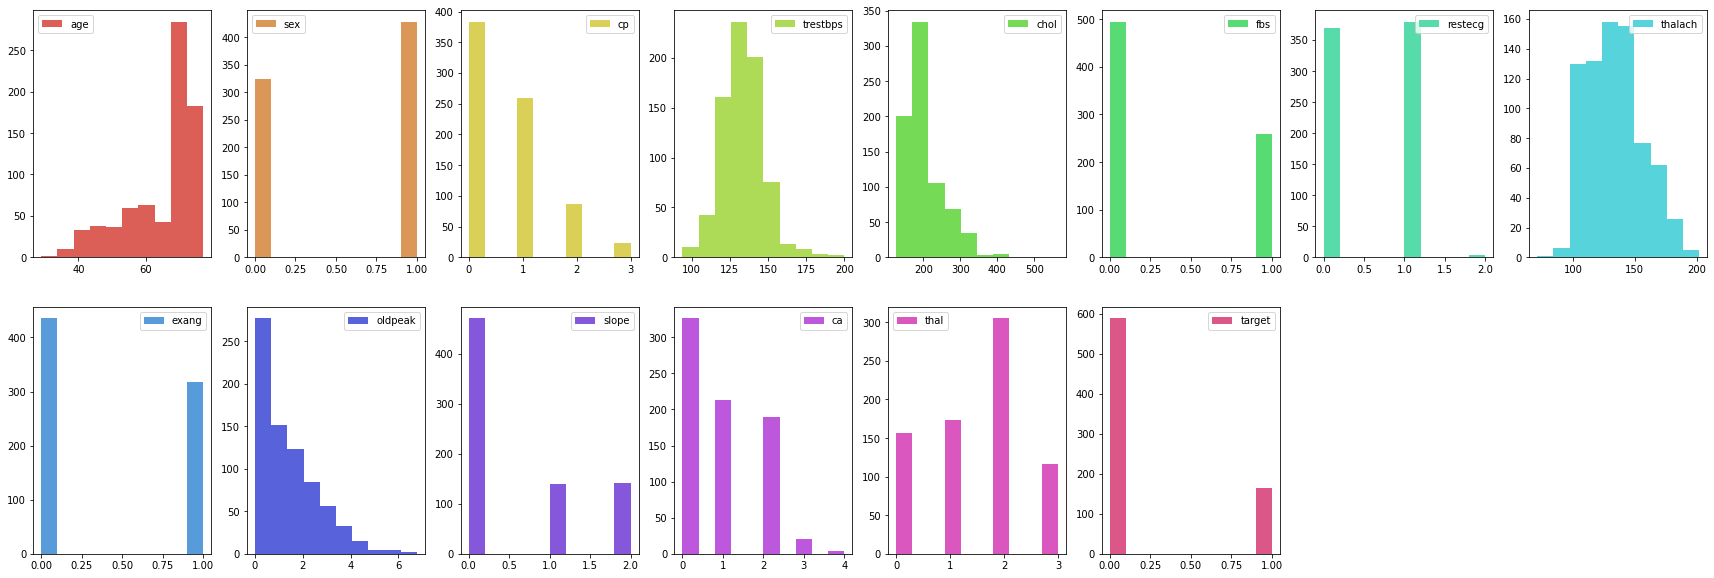

In [285]:
def plot_hist(data, names):
    colors = sns.color_palette("hls", len(names))
    plt.figure(figsize=(30, 10))
    plt.rc('legend', fontsize=10)  
    plt.rc('font', size=10)
    l = len(names)
    a = l // 2 + 1
    b = l // a + 1
    a, b = b, a
    for i in range(l):
        x = plt.subplot(a, b, i + 1)
        val = data[names[i]]
        x.hist(val, color=colors[i], label=names[i]);
        x.legend()
        
plot_hist(data, names)

Работа с выбросами:

target
0    578
1    146
dtype: int64


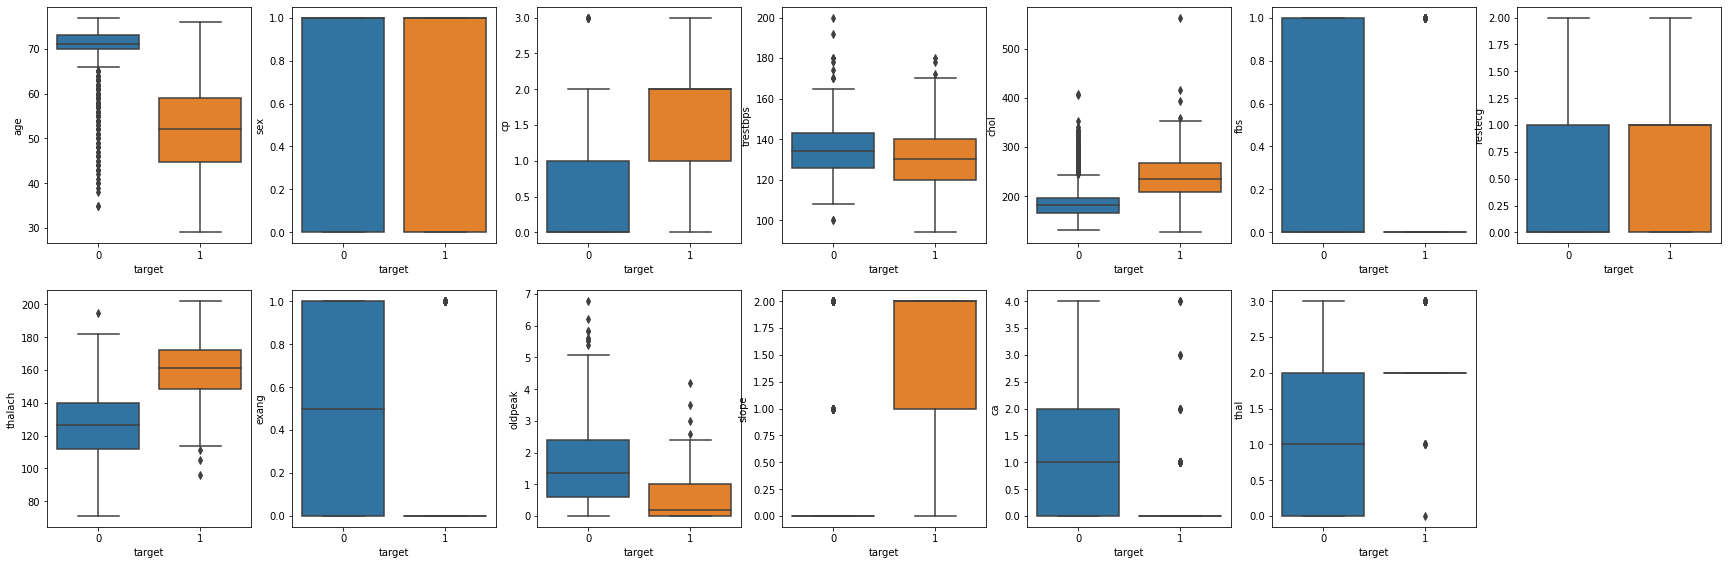

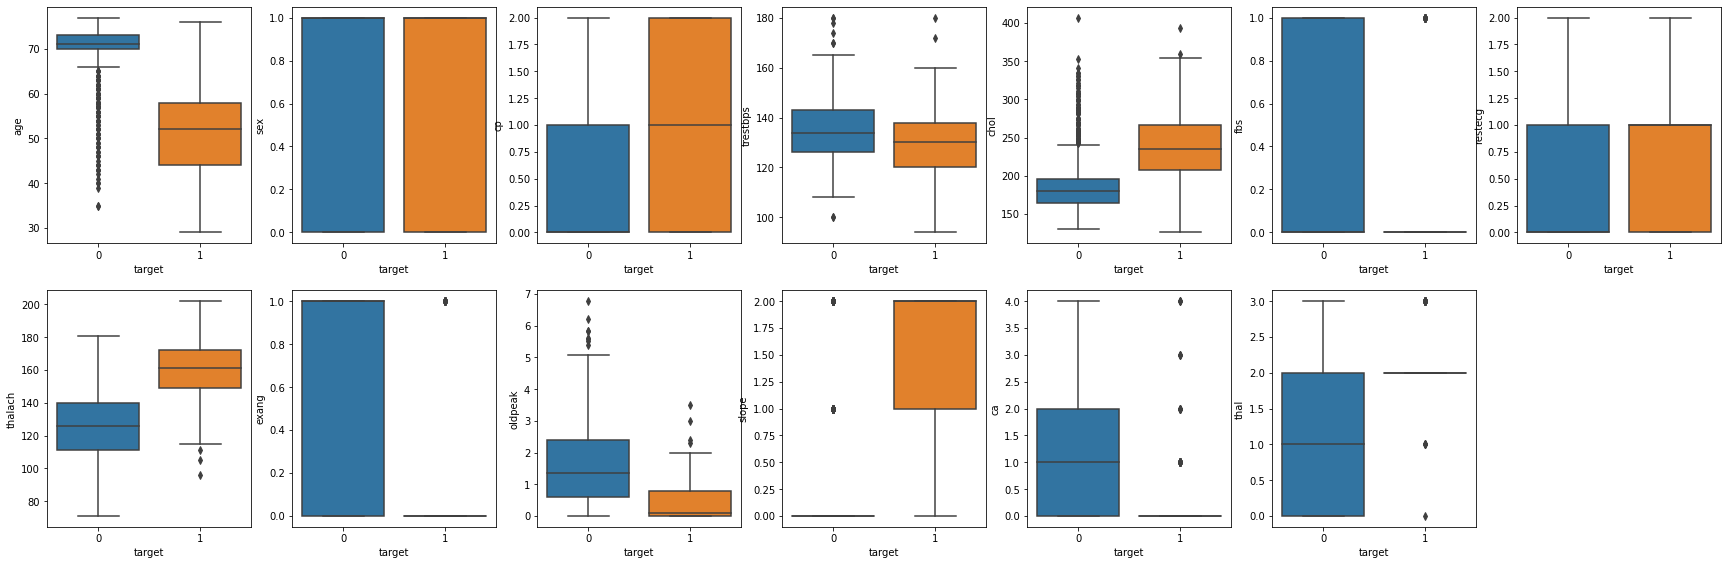

In [286]:
def Plot_box(data, names, target):
    plt.figure(figsize=(30, 20))
    l = len(names)
    a = l // 2 + 1
    b = (l // a + 1) * 2
    a, b = b, a
    ind = 1
    for n in range(l):
        plt.subplot(a, b, ind)
        sns.boxplot(x = data[target] , y = data[names[n]])
        ind += 1
    
    plt.show()

data_IQR = data.copy()
for i in range(0, len(names) - 2):
    qv1 = data[names[i]].quantile(0.15)
    qv2 = data[names[i]].quantile(0.85)
    between = qv2 - qv1
    data_IQR = data_IQR.loc[(data[names[i]] > (qv1 - 1.6 * between)) & (data[names[i]] < (qv2 + 1.6 * between))]

print(data_IQR.groupby('target').size())
Plot_box(data, names[:-1], 'target')
Plot_box(data_IQR, names[:-1], 'target')

Нормализация данных:

In [287]:
display(data.describe())
normalized_data=(data[names[:-1]] - data[names[:-1]].mean())/data[names[:-1]].std()
normalized_data[names[-1]] = data[names[-1]]
display(normalized_data.describe())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000
mean,64.962766,0.569149,0.666223,133.417553,203.336436,0.343085,0.514628,133.884309,0.421543,1.381004,0.561170,0.886968,1.507979,0.218085
std,10.424221,0.495525,0.797150,13.167410,49.542620,0.475056,0.510658,22.383087,0.494135,1.237566,0.788724,0.909626,0.989931,0.413220
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,58.000000,0.000000,0.000000,125.000000,169.000000,0.000000,0.000000,115.000000,0.000000,0.364012,0.000000,0.000000,1.000000,0.000000
50%,70.000000,1.000000,0.000000,132.000000,188.000000,0.000000,1.000000,132.000000,0.000000,1.101973,0.000000,1.000000,2.000000,0.000000
75%,72.000000,1.000000,1.000000,142.000000,227.250000,1.000000,1.000000,147.000000,1.000000,2.102197,1.000000,2.000000,2.000000,0.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.772167,2.000000,4.000000,3.000000,1.000000


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,7.520000e+02,7.520000e+02,7.520000e+02,7.520000e+02,7.520000e+02,7.520000e+02,7.520000e+02,7.520000e+02,7.520000e+02,7.520000e+02,752.000000,7.520000e+02,7.520000e+02,752.000000
mean,3.401534e-16,-7.558965e-17,5.669224e-17,4.724353e-17,-1.889741e-16,-7.558965e-17,-9.212489e-17,-3.401534e-16,-1.889741e-17,-1.700767e-16,0.000000,-5.669224e-17,-7.558965e-17,0.218085
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,0.413220
min,-3.449923e+00,-1.148578e+00,-8.357562e-01,-2.993569e+00,-1.561008e+00,-7.221999e-01,-1.007775e+00,-2.809456e+00,-8.530924e-01,-1.115903e+00,-0.711491,-9.750907e-01,-1.523317e+00,0.000000
25%,-6.679411e-01,-1.148578e+00,-8.357562e-01,-6.392718e-01,-6.930686e-01,-7.221999e-01,-1.007775e+00,-8.436865e-01,-8.530924e-01,-8.217682e-01,-0.711491,-9.750907e-01,-5.131457e-01,0.000000
50%,4.832240e-01,8.694841e-01,-8.357562e-01,-1.076562e-01,-3.095605e-01,-7.221999e-01,9.504851e-01,-8.418448e-02,-8.530924e-01,-2.254674e-01,-0.711491,1.242619e-01,4.970260e-01,0.000000
75%,6.750849e-01,8.694841e-01,4.187122e-01,6.517946e-01,4.826867e-01,1.382817e+00,9.504851e-01,5.859644e-01,1.170647e+00,5.827509e-01,0.556379,1.223615e+00,4.970260e-01,0.000000
max,1.154737e+00,8.694841e-01,2.927649e+00,5.056609e+00,7.279865e+00,1.382817e+00,2.908745e+00,3.043177e+00,1.170647e+00,4.356263e+00,1.824250,3.422320e+00,1.507198e+00,1.000000


Корреляция данных:

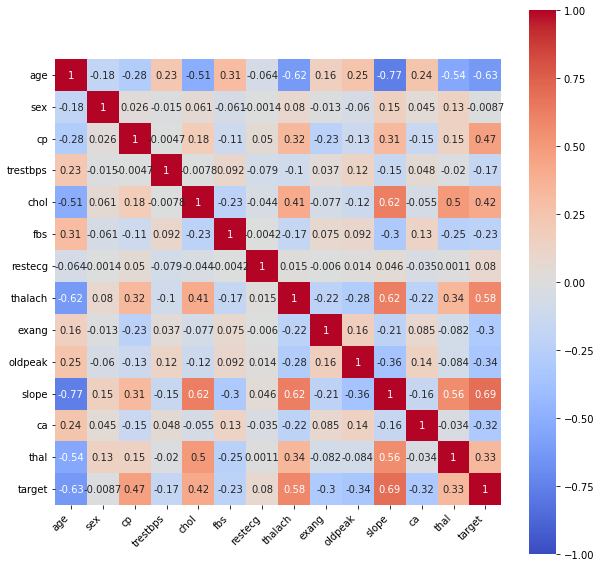

In [288]:
corr = data.corr()
plt.figure(figsize=(10, 10))
ax = sns.heatmap(corr, annot = True, vmin=-1, vmax=1, cmap= 'coolwarm', square=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');
plt.show()

In [289]:
mix_data = data.sample(frac=1).reset_index(drop=True)
data = mix_data

In [290]:
print(data.groupby('target').size())

target
0    588
1    164
dtype: int64


In [291]:
model = sdv.tabular.GaussianCopula()
model.fit(data)
sample = model.sample(800)

print(sdv.evaluation.evaluate(data, sample))
new_data = pd.concat([data, sample.loc[sample['target'] == 1]])
print(new_data.groupby(names[-1]).size())

/Users/valeriabudnikova/Library/Python/3.8/lib/python/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/Users/valeriabudnikova/Library/Python/3.8/lib/python/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale


0.8924905015197568
target
0    588
1    413
dtype: int64


Разделим данные на тренирвочные и тестовые:

In [292]:
df_train = new_data[0: len(data) * 8 // 10]
df_test = new_data[0: len(data) * 2 // 10]

label_train = df_train['target'].to_numpy()
label_test = df_test['target'].to_numpy()

data_train = df_train.drop(columns=['target']).to_numpy()[:,1:]
data_test = df_test.drop(columns=['target']).to_numpy()[:,1:]

data_train.astype(np.float32);
data_test.astype(np.float32);
label_train.astype(np.float32);
label_test.astype(np.float32);



Вспомогательные функции:

In [293]:
from sklearn import metrics
def plot_ConfusionMatrix(y_true, y_pred, title = ""):
    c_matr = metrics.confusion_matrix(y_true, y_pred) 
    disp = metrics.ConfusionMatrixDisplay(c_matr)
    fig, ax = plt.subplots(figsize=(10,10));
    disp.plot(ax=ax);
    disp.ax_.set_title("ConfusionMatrix " + title);

<h2>KNN </h2>

In [294]:
class Softmax:
    def Next(self, z):
        self.z = z
        e = np.exp(z - z.max(axis=1,keepdims=True))
        sum = e.sum(axis=1,keepdims=True)
        self.p = e / sum
        return self.p
    def Back(self, dp):
        back_z = self.p
        return self.p * dp - self.p * (self.p * dp).sum(axis=1, keepdims=True)
        
class KNN():
    def __init__(self, k, countClasses):
        self.k = k
        self.countClasses = countClasses   
    
    def dist (self, a, b):
        return math.sqrt(np.sum(np.power(a - b, 2)))
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        
    def predict(self, data):
        predLables = []
        
        for i, d_i in enumerate(data):
            distance = list()
            for j, d_j in enumerate(self.data):
                distance.append([self.dist(d_j, d_i), self.labels[j]])

            stat_classes = np.zeros(self.countClasses)
            sort_dist = sorted(distance)
            for d in sort_dist[0:self.k]:
                stat_classes[d[1]] += 1
            
            predLables.append(np.argmax(stat_classes))

        return predLables        

    def pred_proba(self, data):
        predLables = []
        s = Softmax()
        for i, d_i in enumerate(data):
            distance = list()
            for j, d_j in enumerate(self.data):
                distance.append([self.dist(d_j, d_i), self.labels[j]])

            stat_classes = np.zeros(self.countClasses)
            sort_dist = sorted(distance)
            for d in sort_dist[0:self.k]:
                stat_classes[d[1]] += 1
            
            predLables.append(stat_classes / np.max(stat_classes))

        return s.Next(np.array(predLables))        

Accuracy: 0.8866666666666667
Precision: 0.7567567567567568
Recall: 0.7777777777777778
F-metric 0.7671232876712328


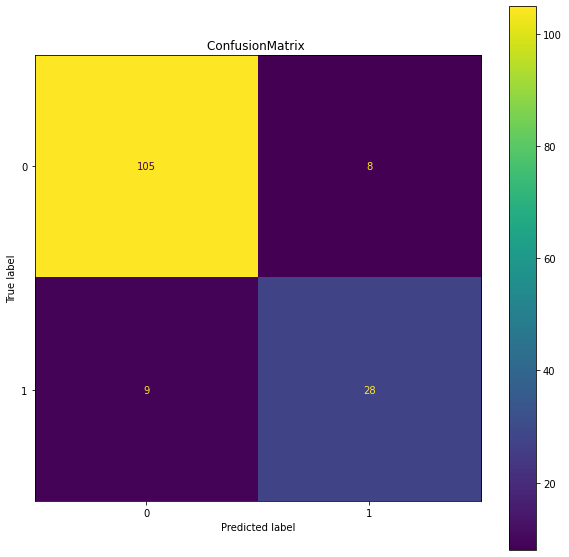

In [295]:
knn = KNN(k = 5, countClasses=3)
knn.fit(data_train, label_train)
pred = knn.predict(data_test)

c_matr = metrics.confusion_matrix(label_test, pred) 
TP = c_matr[1][-1]
FP = c_matr[1][0]
TN = c_matr[0][0]
FN = c_matr[0][1]
accuracy = (pred == label_test).mean()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f_metric = 2 * precision * recall / (precision + recall)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F-metric", f_metric)
plot_ConfusionMatrix(label_test, pred)

Accuracy: 0.8866666666666667
Precision: 0.7567567567567568
Recall: 0.7777777777777778
F-metric 0.7671232876712328


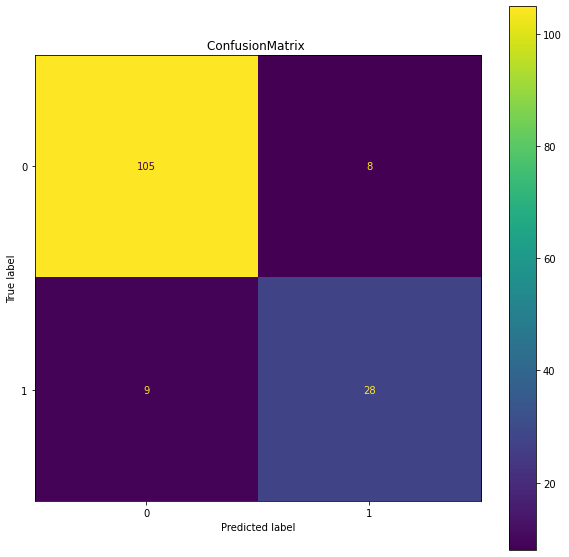

In [296]:
from sklearn.neighbors import KNeighborsClassifier
knn_sk = KNeighborsClassifier()
knn_sk.fit(data_train, label_train)
pred_sk = knn.predict(data_test)

c_matr = metrics.confusion_matrix(label_test, pred_sk) 
TP = c_matr[1][-1]
FP = c_matr[1][0]
TN = c_matr[0][0]
FN = c_matr[0][1]
accuracy = (pred_sk == label_test).mean()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f_metric = 2 * precision * recall / (precision + recall)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F-metric", f_metric)
plot_ConfusionMatrix(label_test, pred_sk)

Жесткое голосование:

In [297]:
from collections import Counter
class Hard_voting:
    def __init__(self, algs):
        self.algs = algs

    def fit(self, data, labels):
        for f in self.algs:
            f.fit(data, labels)
    def predict(self, data):
        predictions = []
        for f in self.algs:
            predictions.append(f.predict(data))

        answ = []
        pr = np.array(predictions).T
        for p in pr:
            answ.append(Counter(p).most_common()[0][0])
        return answ 

Accuracy: 0.96
Precision: 0.8378378378378378
Recall: 1.0
F-metric 0.911764705882353


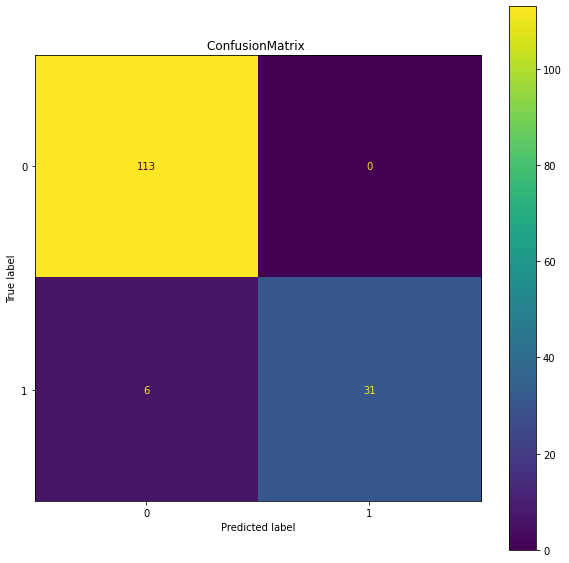

In [298]:
knn1 = KNN(k = 1, countClasses=2)
knn2 = KNN(k = 2, countClasses=2)
knn3 = KNN(k = 5, countClasses=2)
knn4 = KNN(k = 10, countClasses=2)

hv = Hard_voting([knn1, knn2, knn3, knn4])
hv.fit(data_train, label_train)
pred_hv = hv.predict(data_test)

c_matr = metrics.confusion_matrix(label_test, pred_hv) 
TP = c_matr[1][-1]
FP = c_matr[1][0]
TN = c_matr[0][0]
FN = c_matr[0][1]
accuracy = (pred_hv == label_test).mean()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f_metric = 2 * precision * recall / (precision + recall)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F-metric", f_metric)
plot_ConfusionMatrix(label_test, pred_hv)

Мягкое голосование:

In [299]:
class Soft_voting:
    def __init__(self, algs):
        self.algs = algs

    def fit(self, data, labels):
        for f in self.algs:
            f.fit(data, labels)

    def predict(self, data):
        predictions = []
        for f in self.algs:
            predictions.append(f.pred_proba(data).T)
        answ = []
        pr = np.array(predictions).T
        
        for p in pr:
            pp = np.sum(p, axis=1)
            answ.append(np.argmax(pp))
        return answ 

Accuracy: 0.9466666666666667
Precision: 0.8918918918918919
Recall: 0.8918918918918919
F-metric 0.8918918918918919


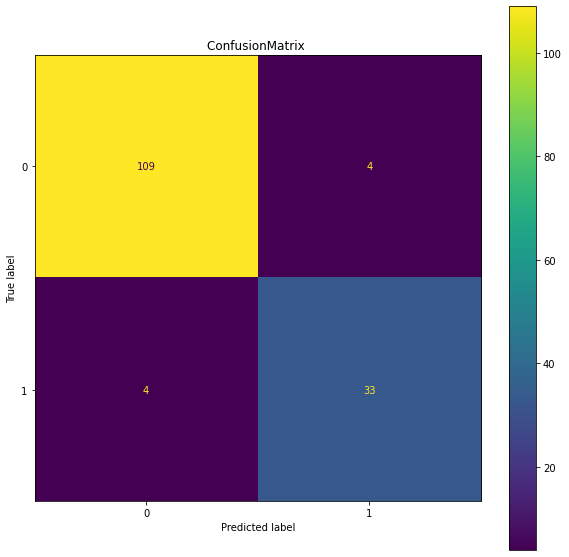

In [300]:
knn1 = KNN(k = 1, countClasses=2)
knn2 = KNN(k = 2, countClasses=2)
knn3 = KNN(k = 5, countClasses=2)
knn4 = KNN(k = 10, countClasses=2)

sv = Soft_voting([knn1, knn2, knn3, knn4])
sv.fit(data_train, label_train)
pred_sv = sv.predict(data_test)


c_matr = metrics.confusion_matrix(label_test, pred_sv) 
TP = c_matr[1][-1]
FP = c_matr[1][0]
TN = c_matr[0][0]
FN = c_matr[0][1]
accuracy = (pred_sv == label_test).mean()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f_metric = 2 * precision * recall / (precision + recall)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F-metric", f_metric)
plot_ConfusionMatrix(label_test, pred_sv)